# Keywords & Titles Clustering Task

## Goal

## Loading Input Data

In [2]:
import pandas as pd
path_to_file  = "nemo_home_asssignment_data.pkl"
input_data_df = pd.read_pickle(path_to_file)
input_data_df.skills = input_data_df.skills.apply(lambda skills: list(skills))
input_data_df

,title_seq,skills
0,"[Principal, Director Business Development]","[data center, Cloud (Computing), Business Deve..."
1,"[Social Worker, Medical Social Worker, Women's...","[Virtual Community, Technical Support, communi..."
2,"[Trainner at the IDF programming school, QA In...","[Mobile Applications, Analysis, Data Structure..."
3,"[Reception, Marketing Manager, Sales Represent...","[Training, Coordination (Organization), market..."
4,"[President, Director, President, Executive Vic...","[marketing, Digital marketing, Digital, accoun..."
...,...,...
9995,"[ATE Engineer, ATE Engineer]","[C#, testing equipment, Design Development, La..."
9996,"[Software Engineer ( Consultant ), Team Leader...","[Training, Technical Support, Auditing, Busine..."
9997,"[Senior Site Manager, Venue Delivery Manager]","[construction, Operations, demolition, project..."
9998,"[Programmer Analyst, Assistant Scholar, Consul...","[translation, Technical Support, Perl, softwar..."


# pre process titles and skills:
remove non alphabetical chars \ 
lowercase and remove redundent spaces \
lemmatize \
 for titles:
 - remove least common words - words that appear only once
 - create tuples of (prev,_job , next_job) 
 - tried to also add tuples with most common words (example: (director,  Director Business Development)) but its too general

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re


def remove_least_common_words(removal_list, sentence):
    sentence = sentence.split()
    for word in sentence:
        if word in removal_list:
            sentence.remove(word)
    return ' '.join(sentence)


def preprocess_column(input_data_df, column, new_column, n=10, min_word_count=2, create_tuples=True):  
    input_data_df[new_column] = input_data_df.loc[:,column]
    input_data_df[new_column] = input_data_df.loc[:,new_column].apply(
        lambda seq: [item.translate ({ord(c): " " for c in "0123456789!@#$%^&*()[]{};:,./<>?\|`~-=_+"}).lower() for item in seq])
 
    lemmatizer = WordNetLemmatizer()

    input_data_df[new_column] = input_data_df.loc[:,new_column].apply(
        lambda seq: [lemmatizer.lemmatize(item) for item in seq])
    
    if create_tuples:
        all_jobs = input_data_df.loc[:,column].values.tolist()
        all_jobs = [item.split(" ") for sublist in all_jobs for item in sublist]
        all_jobs = [item for sublist in all_jobs for item in sublist]

        #most_common_words= [word for word, word_count in Counter(all_jobs).most_common(n)]

        least_common_words= [word for word, word_count in Counter(all_jobs).most_common() if word_count<2]
        print("len(least_common_words)", len(least_common_words))
        least_common_words.append(stopwords.words('english'))

        input_data_df[new_column] = input_data_df.loc[:,new_column].apply(
        lambda seq: [remove_least_common_words(least_common_words, item) for item in seq])
    
    
        all_title_seq = input_data_df.loc[:,new_column].values.tolist()
        title_couples = []
        for seq in all_title_seq :
            for idx in range(len(seq)-1):
                t1 = re.sub(' +', ' ', seq[idx]).lstrip().rstrip()
                t2 = re.sub(' +', ' ', seq[idx+1]).lstrip().rstrip()
                if t1 != '' and t2 != '':
                    title_couples.append((t1, t2))

        #remove tuples with same values
        title_couples = [t for t in title_couples if t[0]!=t[1]]
        #remove duplicates
        title_couples = [t for t in (set(tuple(i) for i in title_couples))]
        return title_couples, input_data_df.loc[:,new_column]
    
    
    input_data_df[new_column] = input_data_df.loc[:,new_column].apply(
        lambda seq: re.sub(' +', ' ', ' '.join(seq).lstrip().rstrip()))
    return input_data_df[new_column].values
    

title_couples, titles_column = preprocess_column(input_data_df, "title_seq", "clean_titles")
skills_clean = preprocess_column(input_data_df, "skills", "clean_skills", create_tuples=False)

len(least_common_words) 9947


In [4]:
len(skills_clean), len(title_couples)

(10000, 31917)

In [5]:
skills_clean

array(['data center cloud computing business development security product development',
       'virtual community technical support communication medium counseling portfolio art',
       'mobile applications analysis data structures content computer programming npd new product development web applications web database',
       ...,
       'construction operation demolition project management design delivery of goods',
       'translation technical support perl software frameworks research design continuous integration ci mobile microsoft access sql structured query language computer performance production economics pl sql monitoring estimation process analysis distributed system telecommunication oracle database tcp ip communication medium software development corrective action plans cap early childhood education integration testing economics team management shell unix script video e learning npd new product development web applications operation management systems internet mysql',
   

# skills model:
train word2vec model including phrases \
generate sentence vector by avaraging the word embeddings (according to NEMO better to max pool but averaging is good enough for now)

In [6]:
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict 

sent = [row.split() for row in skills_clean]

phrases = Phrases(sent, min_count=30) #, progress_per=100)

sentences = phrases[sent]

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

C:\Users\GABRIEVA\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\GABRIEVA\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


1098


['management',
 'development',
 'marketing',
 'product',
 'business',
 'analysis',
 'design',
 'npd_new',
 'technical_support',
 'sale']

In [7]:
import multiprocessing
from gensim.models import Word2Vec
size = 300
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=20,
                     size=size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     sg=1,
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=1000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(866083, 4553580)

In [8]:
# check similar words
w2v_model.wv.most_similar(positive=["nlp"])

[('natural', 0.8788318037986755),
 ('processing', 0.8256319165229797),
 ('ml', 0.7432519197463989),
 ('image', 0.7368853092193604),
 ('machine_learning', 0.7326148748397827),
 ('algorithm', 0.7271888256072998),
 ('science', 0.7047128677368164),
 ('matlab', 0.6461318731307983),
 ('mining', 0.6114081144332886),
 ('biology', 0.5981858372688293)]

In [9]:
import numpy as np
#generate vector of skills for each row
def sentence_to_vec(model, sentence, size):
    sentence_words = sentence.split(" ")
    sent_vec = np.zeros(size)
    for word in sentence_words:
        try:
            sent_vec += w2v_model[word]
        except:
            pass
        
    return sent_vec/len(sentence_words)

skills_vec = []
for sentence in skills_clean:
    skills_vec.append(sentence_to_vec(model=w2v_model, sentence=sentence, size=size))

C:\Users\GABRIEVA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


C:\Users\GABRIEVA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


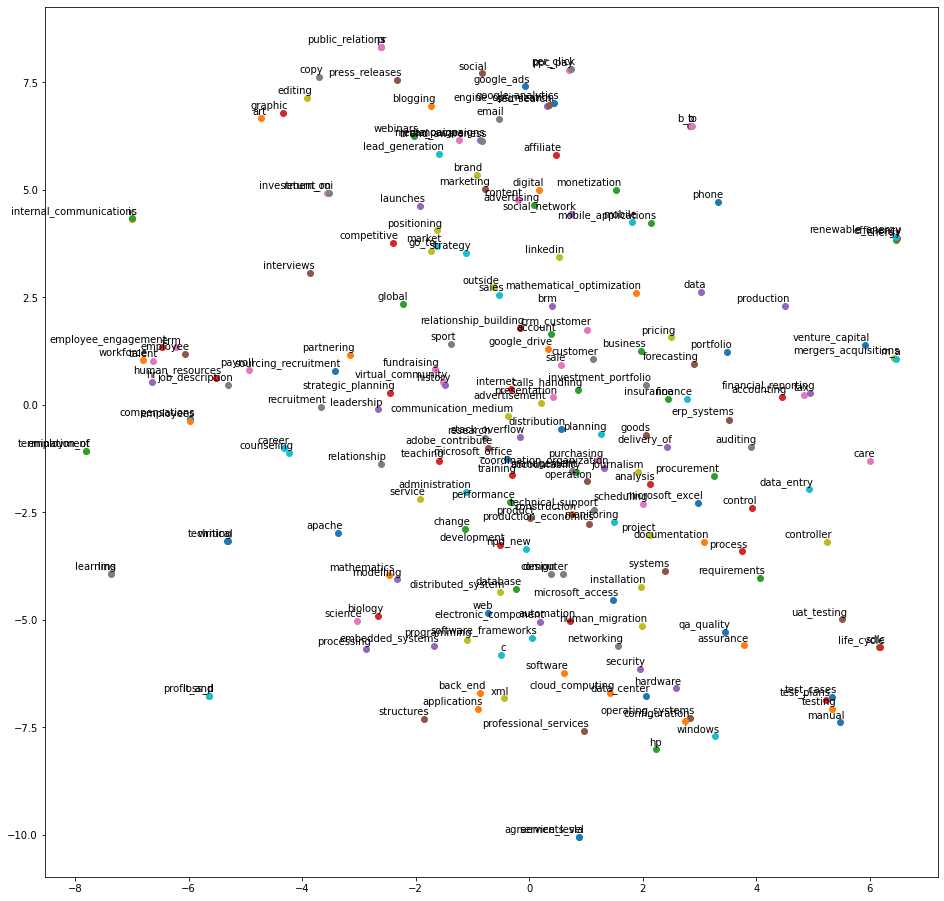

In [10]:
# tsne plot for first 200 words shows more work could be done on the embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(w2v_model.wv.vocab.keys())[:200]:    # model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(w2v_model)

# title model
use poincare distance to learn embeddings that better explain the hierarchial nature of title seqences 

In [11]:
# train a small embedding with small number of epochs because of time constaraints
from gensim.models.poincare import PoincareModel
import time

t0 = time.time()
model = PoincareModel(title_couples, size=20)#, negative=2)
model.train(epochs=50)

t1 = time.time()
t1-t0

123.11166834831238

In [12]:
# example similarities

print(model.kv.similarity("co founder", "quality analyst"))
print(model.kv.similarity('hr manager', 'hr business partner'))
print(model.kv.similarity('social care', 'nurse'))
print(model.kv.similarity('software architect team leader', 'ruby software engineer'))
print(model.kv.similarity('hr manager', 'founder lead recruiter'))
print(model.kv.similarity('marketing', 'marketing consultant'))
print(model.kv.similarity('legal intern', 'english teacher'))

0.23137179381508796
0.6279071945175716
0.957759026199051
0.7174946691763032
0.24375170764793144
0.3098729936154736
0.25929371643963645


# clustering
use DBSCAN with custom metric to generate job title clusters \ 
for each two titles:
- calculate 1 - cosine similarity for relevant skills vectors (since skill vector is equally relevent to all titles in a sequence)
- calculate poincare distance between the two titles
- average the result

In [ ]:
# run DBSCAN for first 500 titles - because slow
from sklearn.metrics.pairwise import cosine_similarity

vocab_list = list(model.kv.vocab.keys())
def custom_dist(i, j):
    i = int(i)
    j = int(j)
    skill_i = np.where(titles_column.apply(lambda seq: vocab_list[i] in seq))[0][0] 
    skill_j = np.where(titles_column.apply(lambda seq: vocab_list[j] in seq))[0][0] 
    dist1 = poincare_dist(i, j)
    dist2 = 1 - cosine_similarity(skills_vec[skill_i].reshape(1, -1), skills_vec[skill_j].reshape(1, -1))[0][0]
    return np.mean([dist1, dist2])
    
    
def poincare_dist(i,j):
    return model.kv.distance(vocab_list[i], vocab_list[j])

from sklearn.cluster import DBSCAN
import numpy as np

dbscan = DBSCAN(eps=0.3, min_samples=3, metric=custom_dist)
dbscan.fit_predict(np.arange(len(vocab_list))[:500].reshape(-1, 1))

In [ ]:
# print titles in a cluster
for l in np.unique(dbscan.labels_):
    if l != -1:
        idxes = np.where(dbscan.labels_ == l)
        print(np.array(vocab_list)[idxes])
        print("------------------------")

In [ ]:
# print k most common words in a cluster
k = 3
for l in np.unique(dbscan.labels_):
    if l != -1:
        idxes = np.where(dbscan.labels_ == l)
        all_jobs = np.array(vocab_list)[idxes]
        all_jobs = [item.split(" ") for item in all_jobs]
        all_jobs = [item for sublist in all_jobs for item in sublist]
        
        print([word for word, word_count in Counter(all_jobs).most_common(k) if word not in stopwords.words('english')])
        print("-------")

In [21]:
# show title graph hierarchy for understanding next job - can make this better with adding the cosine similarity of skills
model.kv.descendants("youth justice case worker", 3)

["women's violence asistance worker",
 'medical social worker',
 'regional coordinator']

# how to evaluate and next steps? 
hierarchy can evaluate compared to "statistically most common next job" ie check what is the most common job sequence after "social worker" \
clustering should be evaluated against simpler models like cosine similarity on tf-idf vectors, or simple w2v on both titles and also manually going over titles in clusters. no time for me to check if my (slower) method actually has any benifits...\

right now hierarchy doesn't take into account the skills vector - so improvement would be to the "custom distance" metric instead of the built-in poincare distnce